In [1]:
library(Cardinal)
library(ggplot2)
library(yaml)

Loading required package: ProtGenerics




Attaching package: ‘ProtGenerics’


The following object is masked from ‘package:stats’:

    smooth


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand

# Hyperparameters

In [ ]:
# Read the hyperparameters from the config file
config <- read_yaml("workspace/config.yml")

# Hyperparameters
lames <- list.files(config$path_to_data)

Warning message in readLines(file, warn = readLines.warn):
“incomplete final line found on 'workspace/config.yml'”


# Concatenate the peaks from all the lames

In [3]:
# Initialize the peaks
peaks <- c()
for (lame in lames) {
  # Load the detected peaks imzml file
  mse_peaks <- readMSIData(sprintf("%s/%s/results/mse_densities.imzML",
                                   config$path_to_data, lame))

  # Change the data centroided attribute to TRUE
  centroided(mse_peaks) <- TRUE

  # Filter the peaks with low frequency
  mse_peaks <- subsetFeatures(mse_peaks, freq > 0.01)

  # Print the number of peaks
  print(sprintf("%s: %d", lame, length(mz(mse_peaks))))

  # Concatenate the peaks
  peaks <- c(peaks, mz(mse_peaks))
}

# Sort the peaks
peaks <- sort(unique(peaks))

[1] "12AG01290_19: 2683"
[1] "12AG01290_26: 2655"
[1] "13AG00043_26: 2186"
[1] "13AG00043-29: 2206"
[1] "13AG00043-36: 2220"
[1] "13AG01113-14: 2059"
[1] "13AG01113-15: 1943"
[1] "13AG03225-06: 2447"
[1] "13AG03225-20: 2071"
[1] "13AG04268-11: 2423"
[1] "14AG03250-31: 2203"
[1] "14AG03250-37: 2092"
[1] "14AG03250-38: 1970"


# Plot the histogram of distances

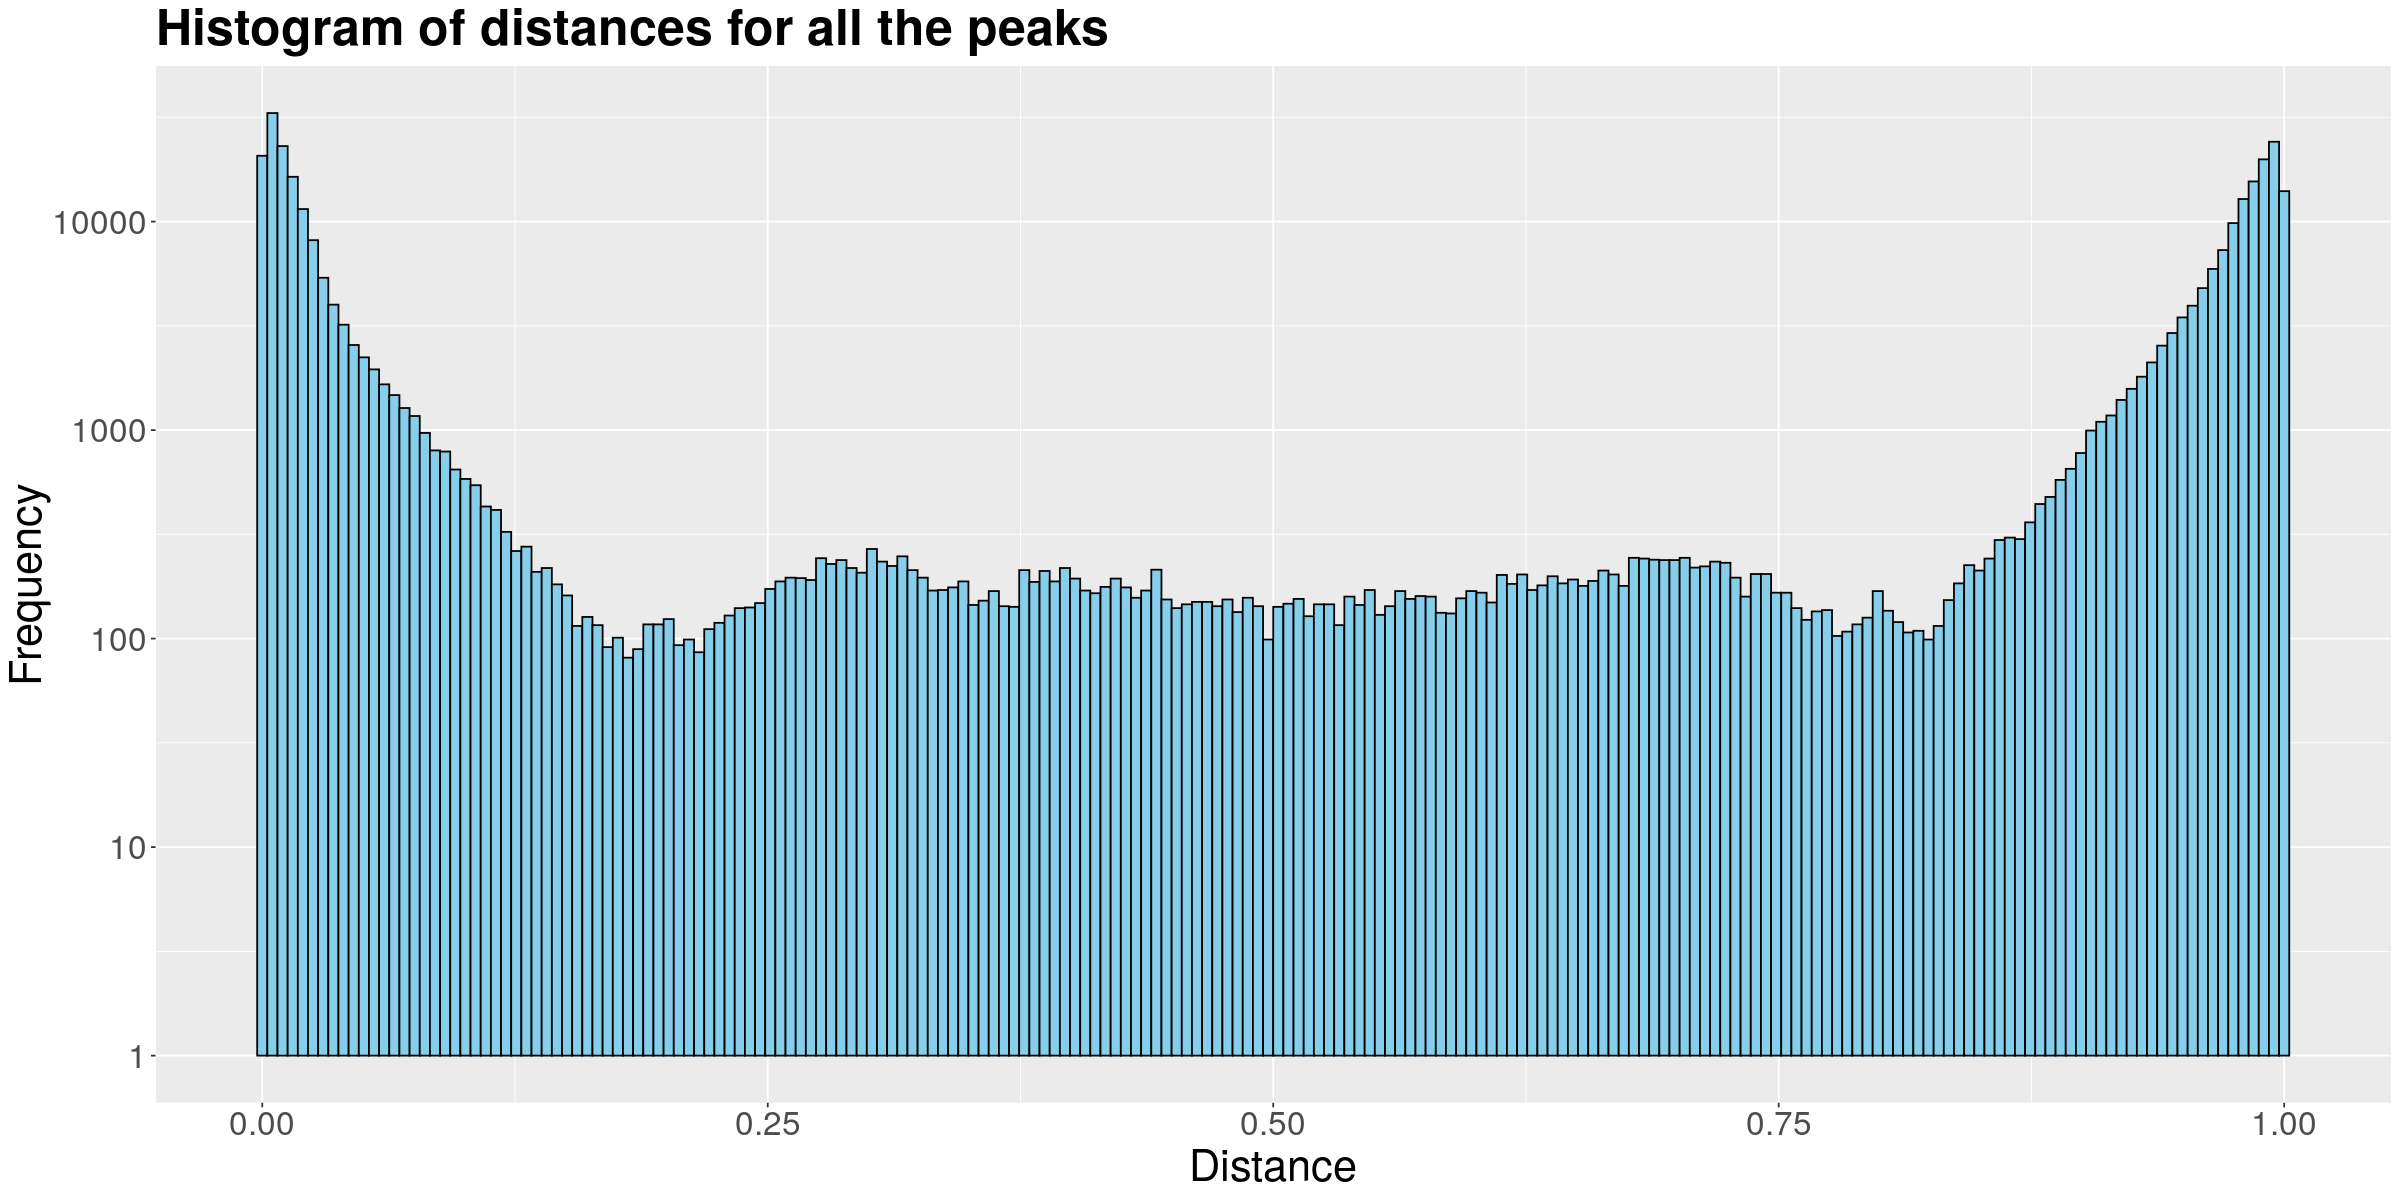

In [4]:
# Compute the distance matrix
distances <- dist(peaks) |> as.vector()

# Exclude the distances > 1
distances <- distances[distances <= 1]

# Plot a histogram of the distances
options(repr.plot.width = 20, repr.plot.height = 10)
ggplot(data.frame(distances = distances), aes(x = distances)) +
  geom_histogram(bins = 200, fill = "skyblue", color = "black") +
  labs(title = "Histogram of distances for all the peaks",
       x = "Distance",
       y = "Frequency") +
  scale_y_log10() +
  theme(plot.title = element_text(size = 30, face = "bold"),
        axis.title = element_text(size = 26),
        axis.text = element_text(size = 20))

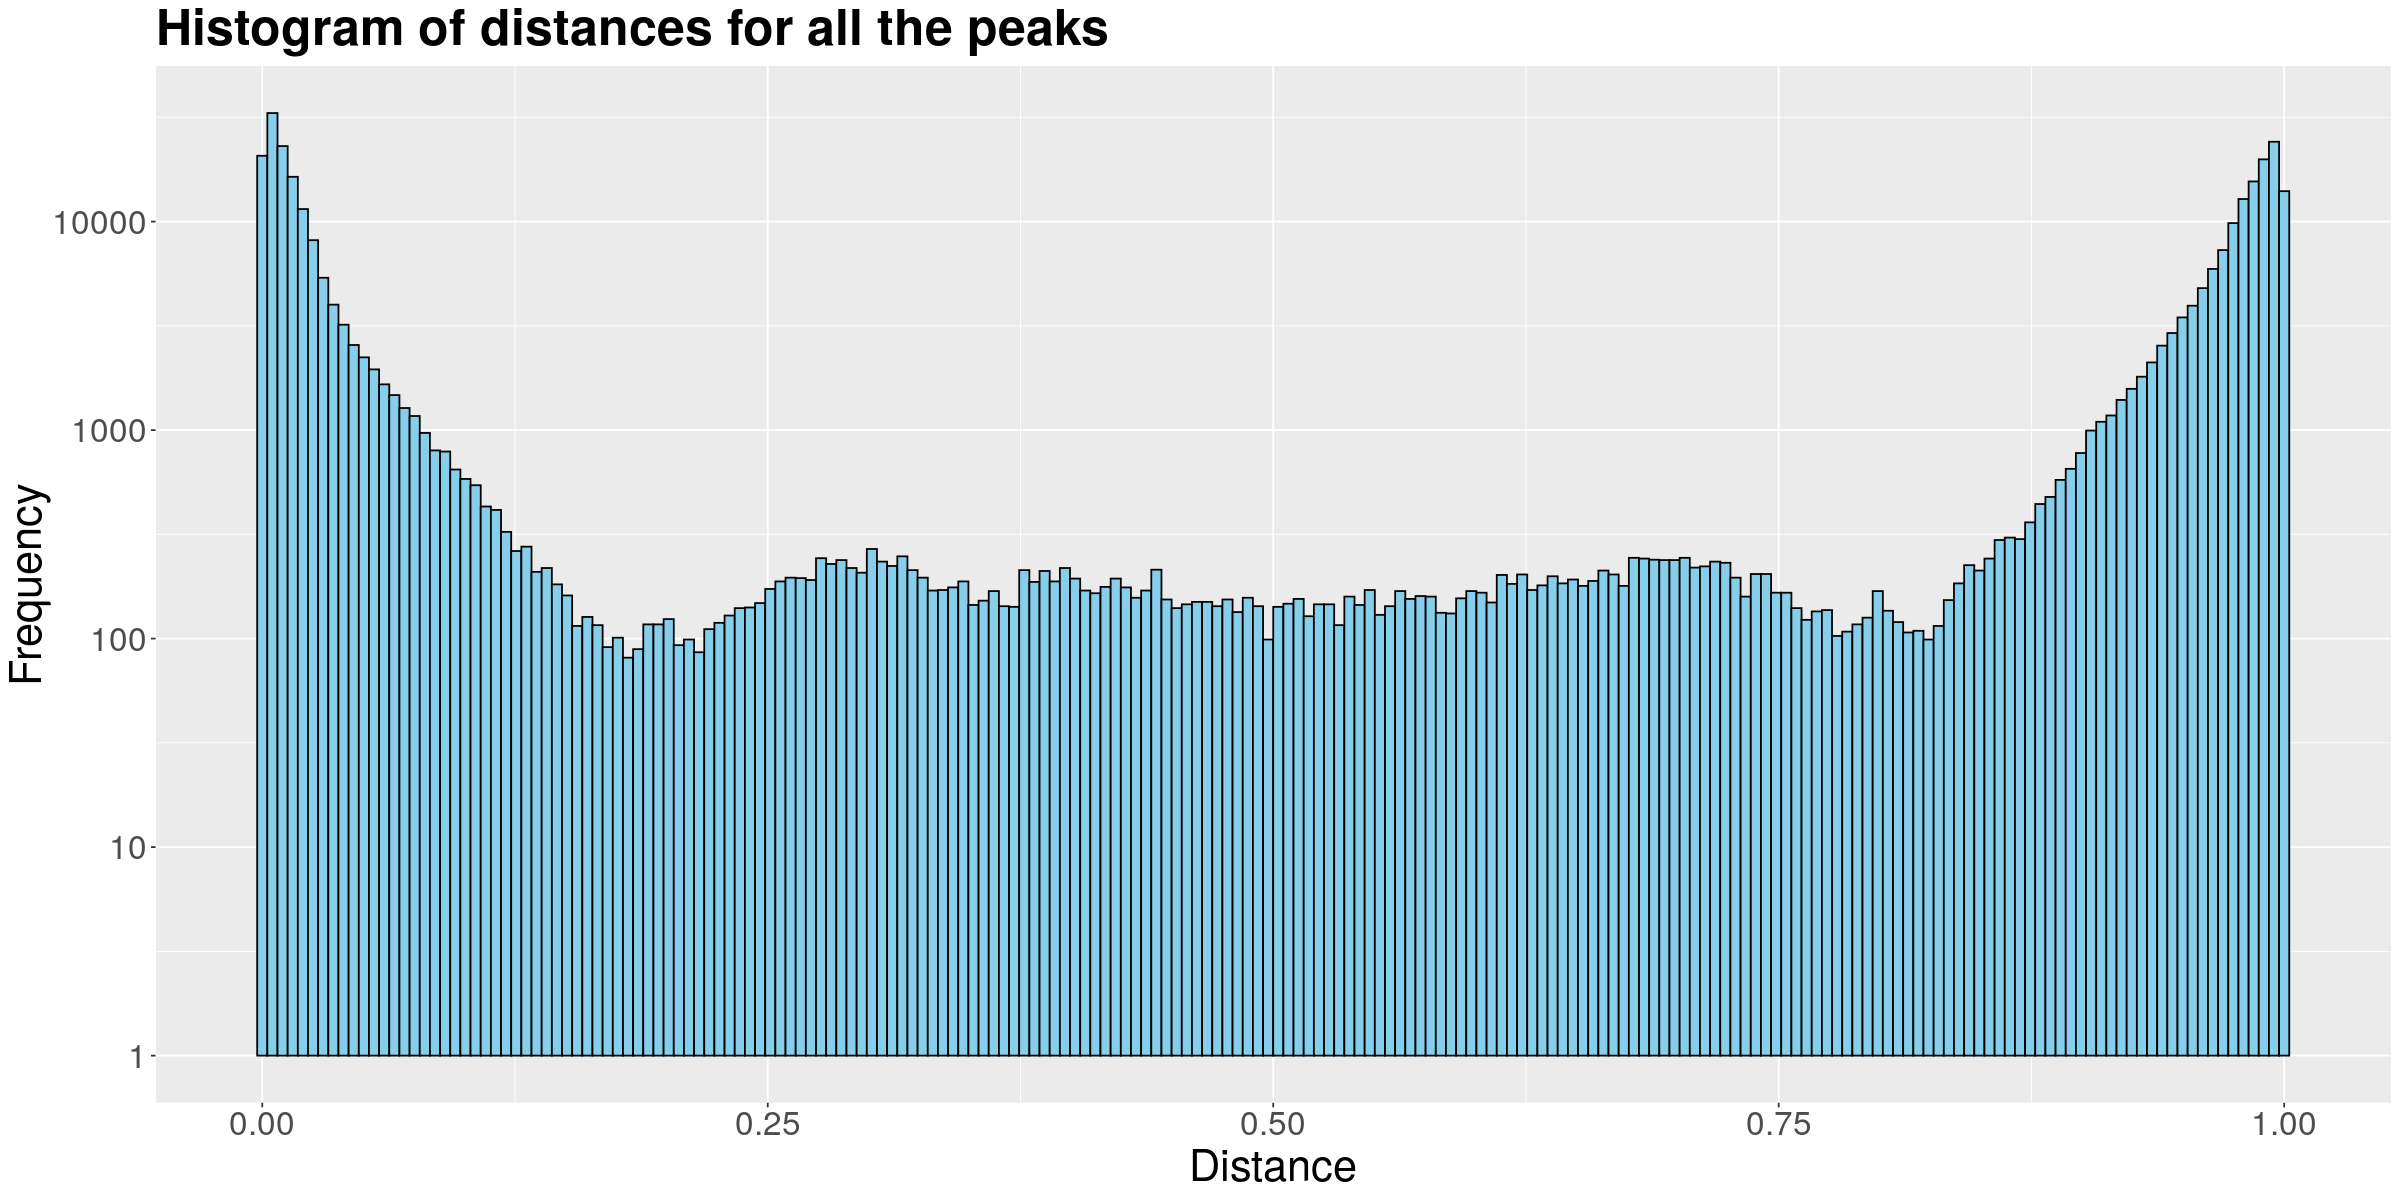

In [5]:
library(ggplot2)

# Plot the histogram with ggplot2
options(repr.plot.width = 20, repr.plot.height = 10)
ggplot(data.frame(distances = distances), aes(x = distances)) +
  geom_histogram(bins = 200, fill = "skyblue", color = "black") +
  labs(title = "Histogram of distances for all the peaks",
       x = "Distance",
       y = "Frequency") +
  scale_y_log10() +
  theme(plot.title = element_text(size = 30, face = "bold"),
        axis.title = element_text(size = 26),
        axis.text = element_text(size = 20))

# Perform a hierarchical clustering to obtain a reference for the peaks

In [6]:
# Perform the hierarchical clustering
clusters <- peaks |>
  dist() |>  # Compute the distance matrix
  hclust(method = "complete") |>  # Perform the hierarchical clustering
  cutree(h = config$clustering_tolerance)  # Tree cut with height = tolerance

# Get the mean of the clusters
reference <- tapply(X = peaks, INDEX = clusters, FUN = mean) |>
  as.numeric()

[1] "Length of all the peaks: 29158"
[1] "Length of the reference: 3594"


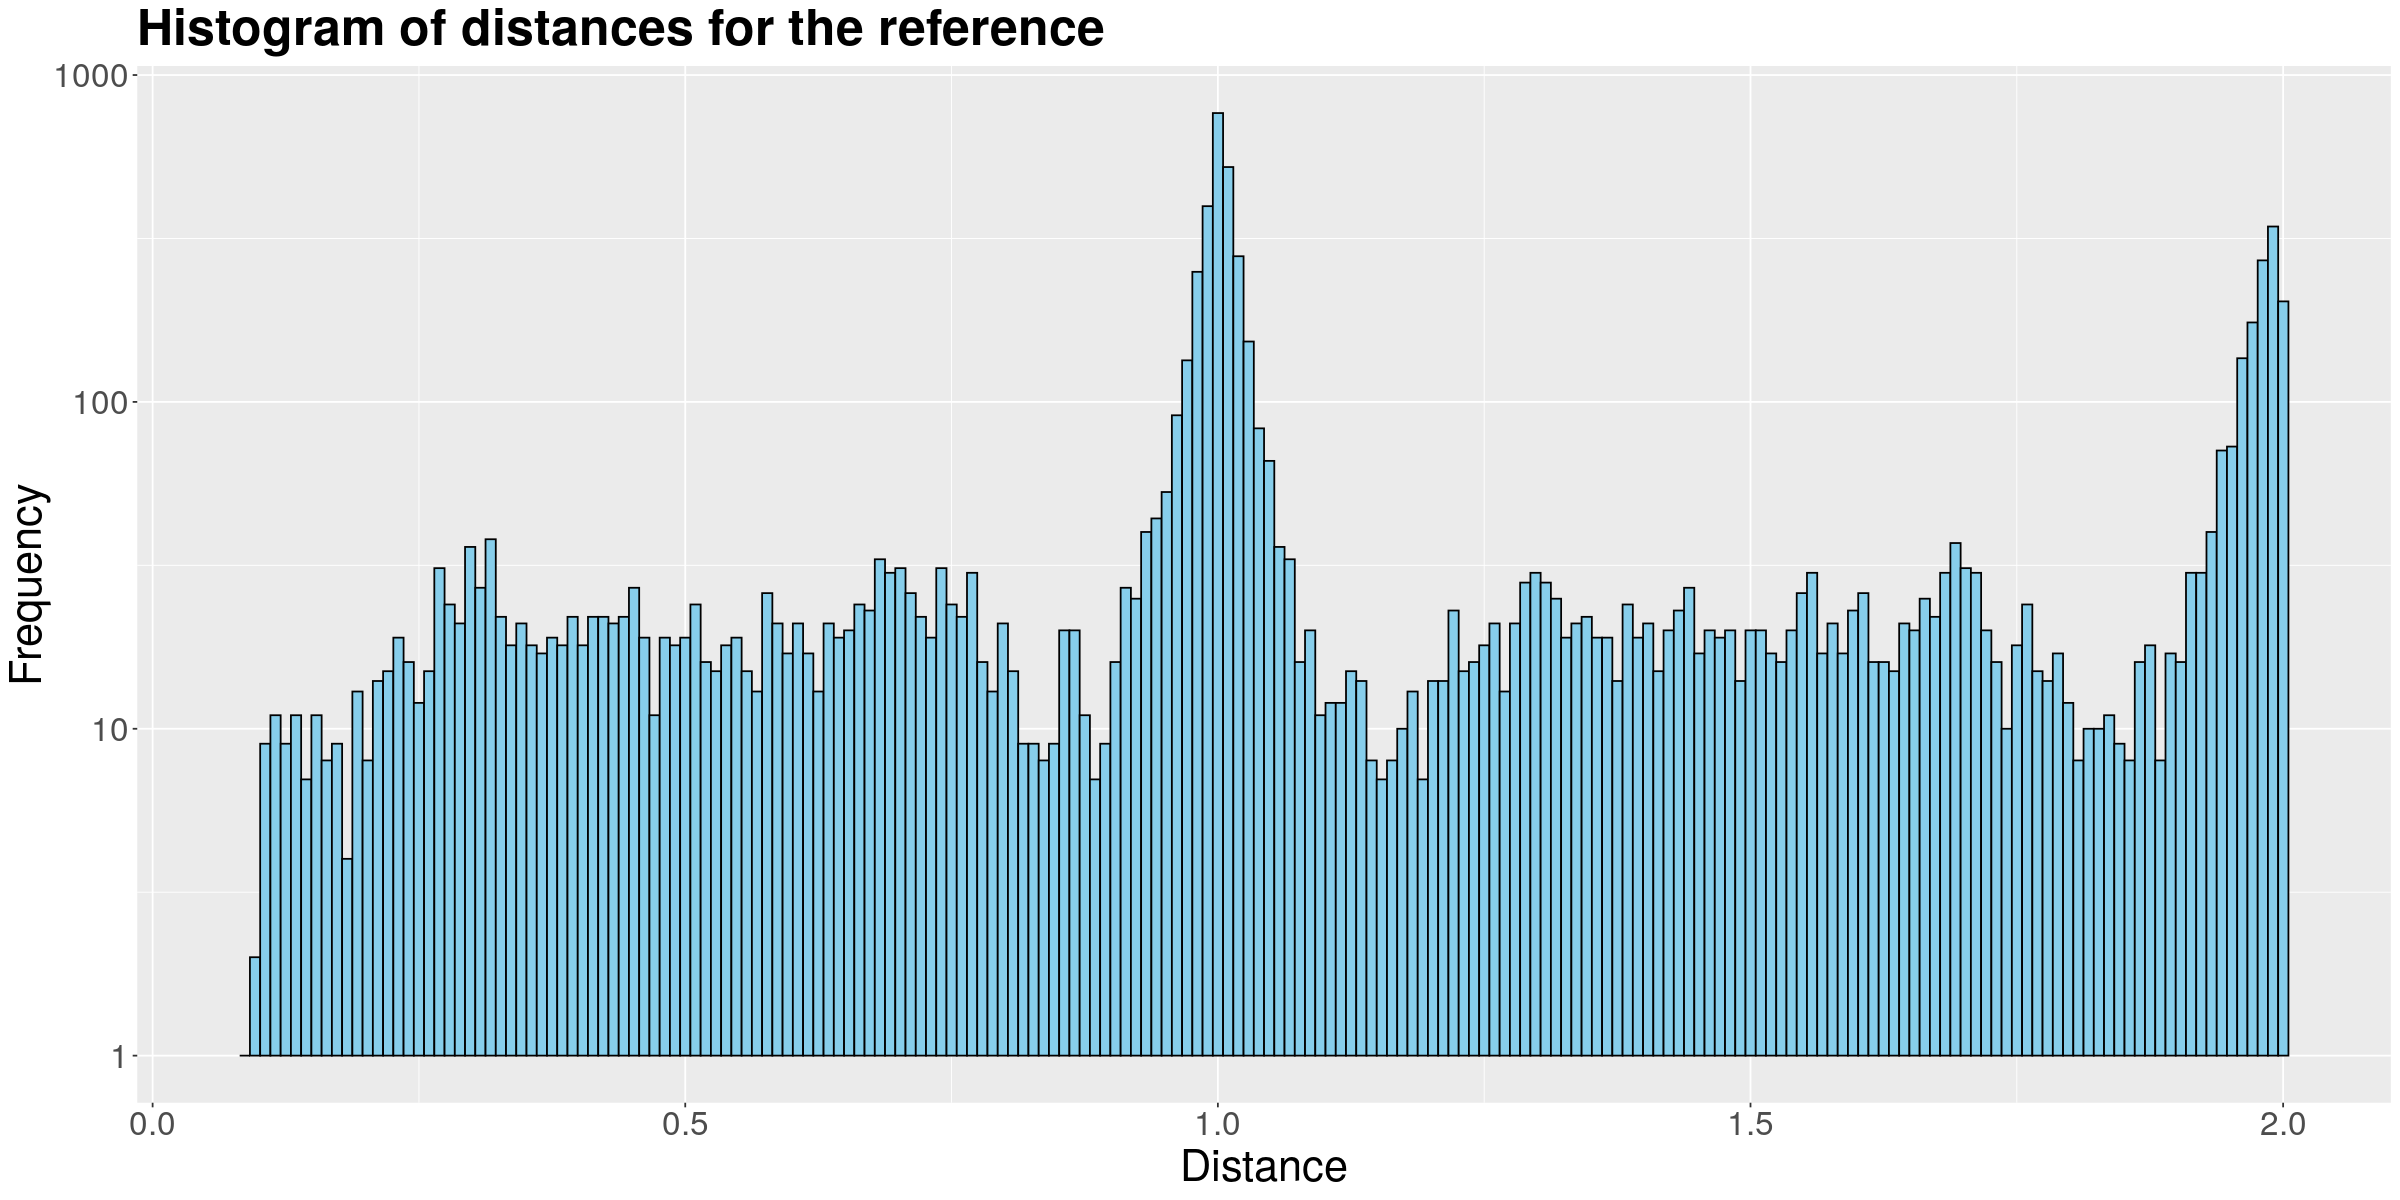

In [10]:
# Compute the distance matrix
distances_ref <- dist(reference) |> as.vector()

# Exclude the distances > 1
distances_ref <- distances_ref[distances_ref <= 2]

# Plot a histogram of the reference distances
options(repr.plot.width = 20, repr.plot.height = 10)
ggplot(data = data.frame(distances = distances_ref), aes(x = distances_ref)) +
  geom_histogram(bins = 200, fill = "skyblue", color = "black") +
  labs(title = "Histogram of distances for the reference",
       x = "Distance",
       y = "Frequency") +
  scale_y_log10() +
  theme(plot.title = element_text(size = 30, face = "bold"),
        axis.title = element_text(size = 26),
        axis.text = element_text(size = 20))

# Print the length of the peaks and the reference
print(sprintf("Length of all the peaks: %d", length(peaks)))
print(sprintf("Length of the reference: %d", length(reference)))

In [8]:
# Save the reference peaks to a file
write.csv(reference, file = "workspace/reference_peaks.csv", row.names = FALSE)